# Dealing with Missing Photometric Data

Part 3.2 of a series of notebooks used to derive the results shown in Speagle et al. (2017).

This notebook outlines how to modify the basic photometric likelihoods derived in Part 3.1 to deal with **missing data**.

## Setup

In [1]:
import sys # system commands
import pickle # saving data
from scipy import stats # statistics functions
from scipy import special # special functions
from scipy import interpolate # interpolation
from sklearn.neighbors import KernelDensity # kernel density estimation

# simulation
import make_sim as sim

# FRANKEN-Z
import frankenz as fz

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Data

As before, we will use our mock SDSS data to benchmark our tests here.

In [2]:
sdss = pickle.load(open( "data/mock_sdss_cosmos_bpz.p", "rb" )) # load data
[types, redshifts, mags], templates = sdss.samples, sdss.samples_t # import truth labels

## Dealing with Missing Data: Theory

In practice, we don't observe every galaxy in every band. This can be due to physical reasons such as non-overlapping photometric coverage as well as algorithmic reasons such as photometric extraction failures. Regardless, since our likelihoods should only be computed where we have data (i.e. overlapping bands), missing data introduces a $p \times 1$ **band mask** vector $\boldsymbol{\beta}(g|h)$ over our $p$ bands, with binary elements that evaluate to one for $b \in \mathbf{b}_{gh}$ and zero otherwise. (We've already been using such masks in our likelihoods.)

Assuming our observed flux densities and associated covariances are defined over all bands and defining 

$$
\underline{\mathbf{\hat{C}}}_{g+h}^{-1} \equiv \mathbf{B}(g|h) \bullet \mathbf{\hat{C}}_{g+h}^{-1} \quad \mathrm{given} \quad
\mathbf{B}(g|h) \equiv \left[\boldsymbol{\beta}(g|h)\right]\left[\boldsymbol{\beta}(g|h)\right]^T
$$

to be the masked precision matrix between galaxies $g$ and $h$, our original likelihoods can be rewritten as

$$
-2 \ln P(g|h) = ||\Delta\mathbf{\hat{F}}_{gh}||_{\underline{\mathbf{\hat{C}}}_{g+h}^{-1}} + \underline{\delta}(g|h), \quad
-2 \ln P_C(g|h) = ||\Delta\mathbf{\hat{F}}_{gh}(\alpha_{\mathrm{ML}})||_{\underline{\mathbf{\hat{C}}}_{g}^{-1}} + \underline{\delta}_C(g|h)
$$

where $\underline{\delta}(g|h)$ and $\underline{\delta}_C(g|h)$ have now absorbed changes from our band mask.

As shown in Speagle et al. (2017), the fact that our errors are Gaussian gives us powerful insight into how these quantities behave. Specifically, they follow the **non-central chi-square** distribution (plus a constant offset)

$$
-2\ln P(g|h) \sim \chi^2_p(\lambda_p) + \underline{\delta}_p(g|h), \quad
-2 \ln P_C(g|h) \sim \chi^2_{p-1}(\lambda_{C,p-1}) + \underline{\delta}_{C,p-1}(g|h)
$$

where $(p, p-1)$ specifies the degrees of freedom and $(\lambda_p, \lambda_{C,p-1})$ specifies the non-centrality parameters. We show a concrete example below.

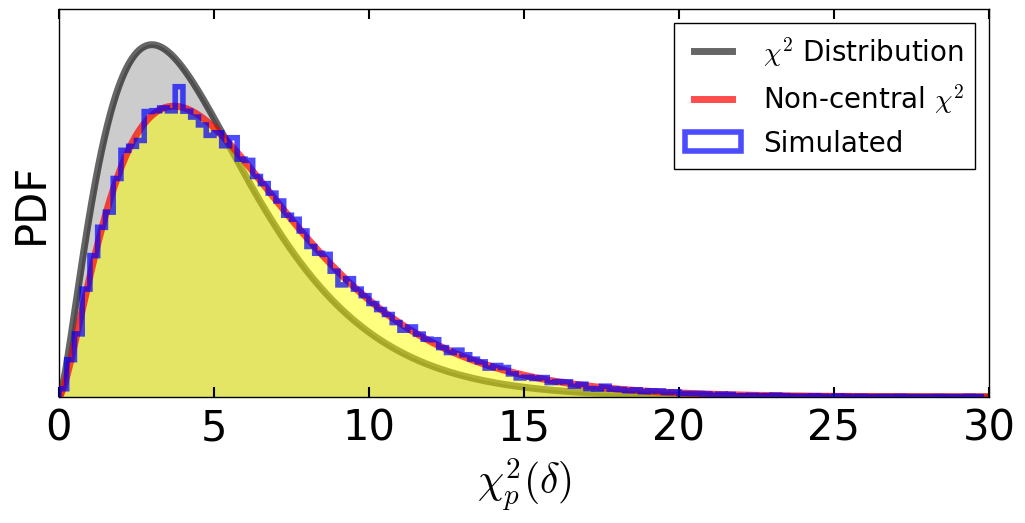

In [3]:
# initialize distribution
x = arange(0,30,0.01) # grid
dof = sdss.NFILTER # degrees of freedom
dif = sum( (sdss.phot[0]-sdss.phot[1])**2 / (sdss.noise[0]**2 + sdss.noise[1]**2) ) # non-centrality
pdf = stats.ncx2.pdf(x, dof, dif) # non-central chi2 PDF
pdf2 = stats.chi2.pdf(x, dof) # chi2 PDF

# simulate results
difs = array([sum( (normal(sdss.phot[0],sdss.noise[0]) - normal(sdss.phot[1],sdss.noise[1]))**2 
                  / (sdss.noise[0]**2 + sdss.noise[1]**2) ) for i in xrange(50000)])

# observed value
chi2_obs = sum( (sdss.phot_obs[0]-sdss.phot_obs[1])**2 / (sdss.noise[0]**2 + sdss.noise[1]**2) ) # non-centrality

# plotting
figure(figsize=(12,5))
plot(x, pdf2, color='black', lw=5, alpha=0.6, zorder=1, label='$\chi^2$ Distribution')
fill_between(x, pdf2, color='gray', alpha=0.4, zorder=1)
plot(x, pdf, color='red', lw=5, alpha=0.7, zorder=2, label='Non-central $\chi^2$')
fill_between(x, pdf, color='yellow', alpha=0.5, zorder=2)
hist(difs, x[::25], histtype='step', normed=True, lw=4, alpha=0.7, zorder=3, label='Simulated')
legend(fontsize=20, loc='best')
xlabel('$\chi^2_p(\delta)$')
yticks([])
ylim([0, pdf2.max()*1.1])
ylabel('PDF')

Of course, the issue is that we don't have access to the true underlying distribution, but rather just the single realization that comprises our observation. So to derive our underlying likelihood, we'd have to marginalize over all possible values of the non-centrality parameter.

This is computationally infeasible to do in practice. Instead, we propose to instead implement a first-order correction using the **expected value** of our target distributions. As shown in Speagle et al. (2017), this simplifies our original expressions enormously, giving

$$
\boxed{
-2\ln P(g|h) \equiv ||\Delta\mathbf{\hat{F}}_{gh}||_{\underline{\mathbf{\hat{C}}}_{g+h}^{-1}} - p
}, \quad 
\boxed{
-2 \ln P_C(g|h) \equiv ||\Delta\mathbf{\hat{F}}_{gh}(\alpha_{\mathrm{ML}})||_{\underline{\mathbf{\hat{C}}}_g^{-1}} - (p-1)
}
$$

which amounts to simply normalizing our computed Mahalanobis norms by the dimensionality of the fit. This has already been included in our *loglikelihood(...)* and *loglikelihood_s(...)* functions (hinted at in a previous notebook).

## Dealing with Missing Data: Application

While deriving an approximately band-invariant version of our likelihood is useful, we also need to be able to deal with missing data in our nearest-neighbor searches. In other words, we need a way to quickly **impute** missing observables in an (approximately) unbiased way.

Let's first initialize the censored datasets we will use for validating performance. In addition, we will apply two different **selection functions** to our training and testing data to simulate the case where our training data is significantly deeper than our testing data. Such a case arises often in practice if we're taking data observed in small, deep fields (e.g., COSMOS) and trying to apply them to a wider survey (e.g., SDSS).

In [4]:
# dividing into training/testing samples
Nobs = sdss.NSAMPLES
Ntrain, Ntest = 100000, 50000

sel_train = arange(Nobs)[sdss.phot_obs[:,2] / sdss.noise[:,2] > 2.] # r-band S/N>1 cut
train_sel = sel_train[:Ntrain] # training set

sel_test = arange(Nobs)[sdss.phot_obs[:,2] / sdss.noise[:,2] > 10.] # r-band S/N>10 cut
test_sel = sel_test[sel_test>train_sel[-1]][:Ntest] # testing set

print 'Number of observed galaxies (all):', Nobs
print 'Number of training galaxies:', Ntrain
print 'Number of testing galaxies:', Ntest

Number of observed galaxies (all): 500000
Number of training galaxies: 100000
Number of testing galaxies: 50000


In [5]:
# initializing photometry
phot_train, phot_test = sdss.phot_obs[train_sel], sdss.phot_obs[test_sel]
err_train, err_test = sdss.noise[train_sel], sdss.noise[test_sel]

# initializing masks
mask = random.uniform(size=(Ntrain+Ntest, sdss.NFILTER)) > 0.05 # randomly censor 5% of observations
mask[:,2] = True # always detected in r-band (used for selection)
mask_train, mask_test = mask[:Ntrain], mask[Ntrain:Ntrain+Ntest]

csel_train, csel_test = mask_train.sum(axis=1) < sdss.NFILTER, mask_test.sum(axis=1) < sdss.NFILTER

print 'Number of censored training objects:', csel_train.sum()
print 'Number of censored testing objects:', csel_test.sum()

Number of censored training objects: 18504
Number of censored testing objects: 9363


In [6]:
# initialize asinh magnitudes (Luptitudes)
flux_zeropoint = 10**(-0.4*-23.9) # AB magnitude zeropoint
mag, magerr = fz.asinh_mag_map(sdss.phot_obs, sdss.noise, # map f_nu to asinh mag
                               skynoise=sdss.FDEPTHS, zeropoints=flux_zeropoint) # softening parameter and zero-point

# read FRANKEN-Z config files (to get dictionaries)
config = fz.ReadParams('config/frankenz.config')

# initialize supplementary dictionaries
mdict = fz.PDFDict(config.CONFIG_MAG.params) # magnitude dict
cdict = fz.PDFDict(config.CONFIG_COLOR.params) # color dict
magidx, mageidx = mdict.fit(mag, magerr) # discretized magnitudes

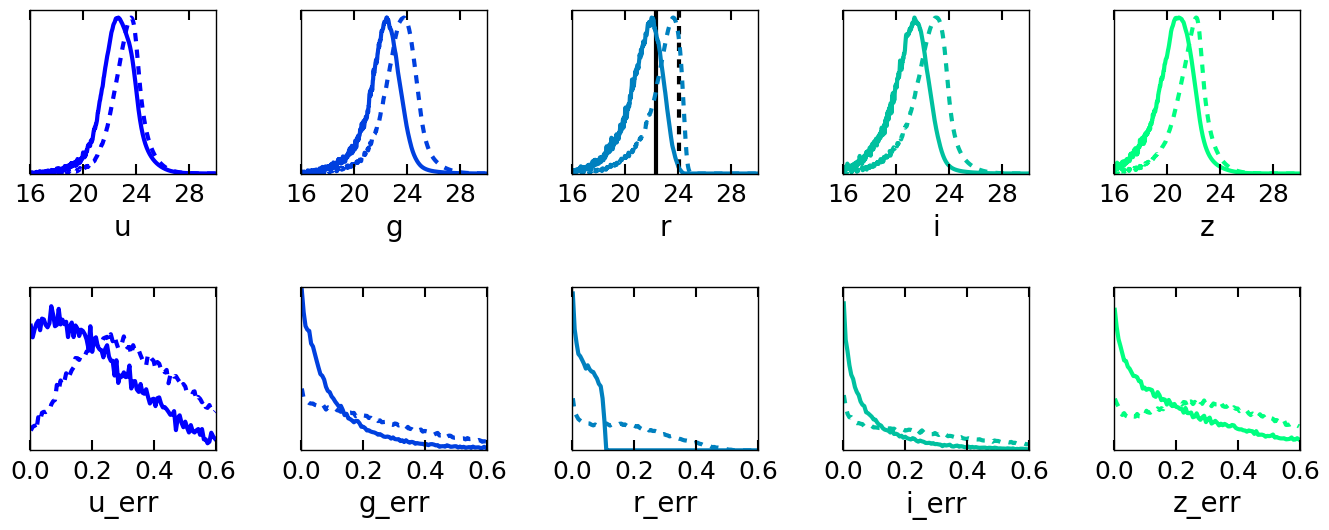

In [7]:
# plotting magnitude distribution
fcolors=get_cmap('winter')(linspace(0,1,sdss.NFILTER)) # filter colors
figure(figsize=(14,6))
for i in xrange(sdss.NFILTER):
    subplot(2,sdss.NFILTER,i+1)
    mag_pdf = fz.pdf_kde_dict(mdict.sig_dict, mdict.sig_width, magidx[train_sel,i], mageidx[train_sel,i], ones(Ntrain),
                              mdict.grid, mdict.delta, Ntrain, mdict.Ngrid)
    plot(mdict.grid, mag_pdf/mag_pdf.max(), lw=3, linestyle='--', color=fcolors[i]) # training data
    mag_pdf = fz.pdf_kde_dict(mdict.sig_dict, mdict.sig_width, magidx[test_sel,i], mageidx[test_sel,i], ones(Ntest),
                              mdict.grid, mdict.delta, Ntest, mdict.Ngrid)
    plot(mdict.grid, mag_pdf/mag_pdf.max(), lw=3, color=fcolors[i]) # testing data
    if i==2: 
        vlines(sdss.MDEPTHS[i]-2.5*log10(2./5.), mag_pdf.max()*1.05, mag_pdf.min(), color='black', lw=3, linestyles='--')
        vlines(sdss.MDEPTHS[i]-2.5*log10(10./5.), mag_pdf.max()*1.05, mag_pdf.min(), color='black', lw=3)
    xlim([16, 30])
    yticks([])
    ylim([None,1.05])
    xticks(arange(16,30,4), fontsize=18)
    xlabel(sdss.filters[i], fontsize=20)
    tight_layout()
    subplot(2,sdss.NFILTER,i+1+sdss.NFILTER)
    h, bins = histogram(magerr[train_sel,i], normed=True, range=[0,0.6], bins=100)
    plot((bins[:-1]+bins[1:])/2., h, lw=3, color=fcolors[i], linestyle='--') # training data
    h, bins = histogram(magerr[test_sel,i], normed=True, range=[0,0.6], bins=100)
    plot((bins[:-1]+bins[1:])/2., h, lw=3, color=fcolors[i]) # testing data
    xticks(linspace(0,0.6,4), fontsize=18)
    xlabel(sdss.filters[i]+'_err', fontsize=20)
    yticks([])
    tight_layout()

In [8]:
# initialize redshift dictionary
rdict = fz.RedshiftDict(config.CONFIG_REDSHIFT.params)

# add names so easier to reference later
rdict.sig_dict = rdict.lze_dict
rdict.sig_width = rdict.lze_width
rdict.delta = rdict.dlz_highres
rdict.grid = rdict.lzgrid_highres
rdict.Ngrid = rdict.Nz_highres

# discretize redshifts
lzidx, lzeidx = rdict.fit(log(1+redshifts), ones(Nobs)*rdict.dlz) # discretized ln(1+z)

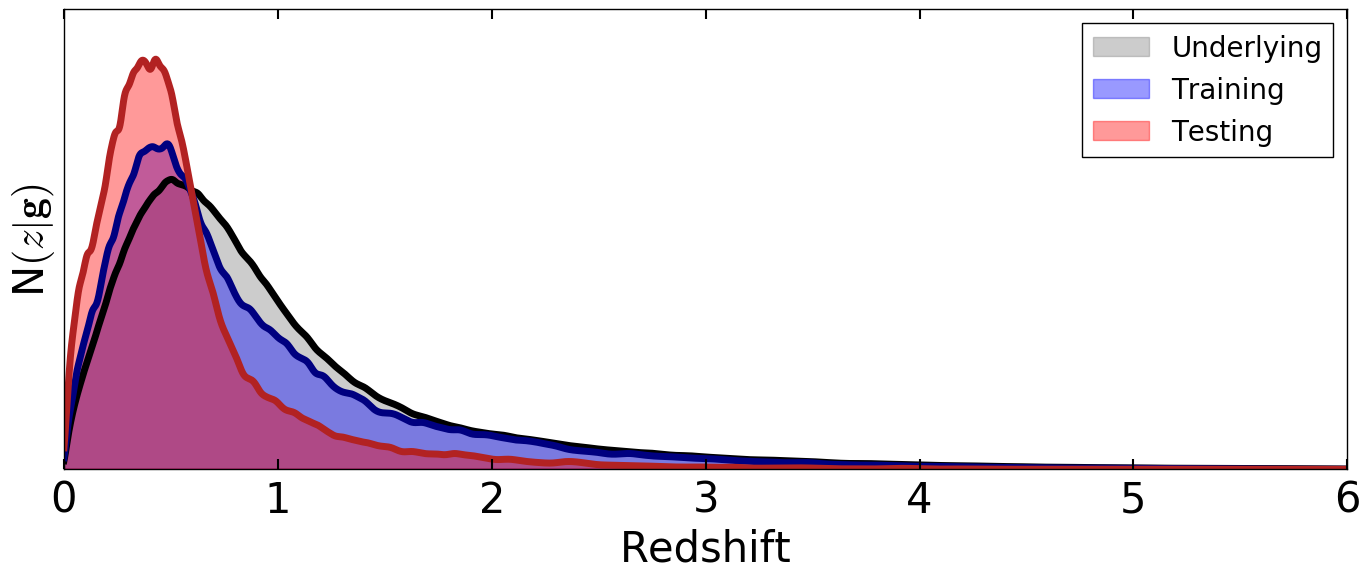

In [9]:
# plotting redshift distribution
figure(figsize=(14,6))

# all
z_pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx, lzeidx, ones(Nobs),
                       rdict.grid, rdict.delta, Nobs, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf = z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_pdf /= z_pdf.sum() # normalizing
plot(rdict.zgrid_highres, z_pdf, lw=5, color='black')
fill_between(rdict.zgrid_highres, z_pdf, color='gray', alpha=0.4, label='Underlying')

# training
z_pdf_train = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel], lzeidx[train_sel], ones(Ntrain),
                              rdict.grid, rdict.delta, Ntrain, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf_train = z_pdf_train[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_pdf_train /= z_pdf_train.sum() # normalizing
plot(rdict.zgrid_highres, z_pdf_train, lw=5, color='navy')
fill_between(rdict.zgrid_highres, z_pdf_train, color='blue', alpha=0.4, label='Training')

# testing
z_pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[test_sel], lzeidx[test_sel], ones(Ntest),
                        rdict.grid, rdict.delta, Ntest, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf = z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_pdf /= z_pdf.sum() # normalizing
plot(rdict.zgrid_highres, z_pdf, lw=5, color='firebrick')
fill_between(rdict.zgrid_highres, z_pdf, color='red', alpha=0.4, label='Testing')

xlim([0, 6])
yticks([])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('N$(z|\mathbf{g})$')

### Out-of-the-Box Method: FancyImpute

This problem isn't unique to astronomy: in general, many fields are interested in solving some version of the problem of filling in an arbitrary set of missing values within an $n \times m$ matrix. As such, it's not crazy to think that general-purpose solutions might exist that we can exploit. A good example of a package that does just this is [**FancyImpute**](https://github.com/hammerlab/fancyimpute), which we will quickly test below. (Note that FancyImpute actually has quite a few dependencies, so be careful when/if installing.)

In [10]:
import fancyimpute

Using Theano backend.


FancyImpute can use a range of methods. Here, we will take advantage of **MICE** (Multiple Imputation by Chained Equations), which attempts to impute the missing values of the matrix directly. Using Monte Carlo methods, we can probe the approximate distribution of imputed values based on our measurement errors.

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

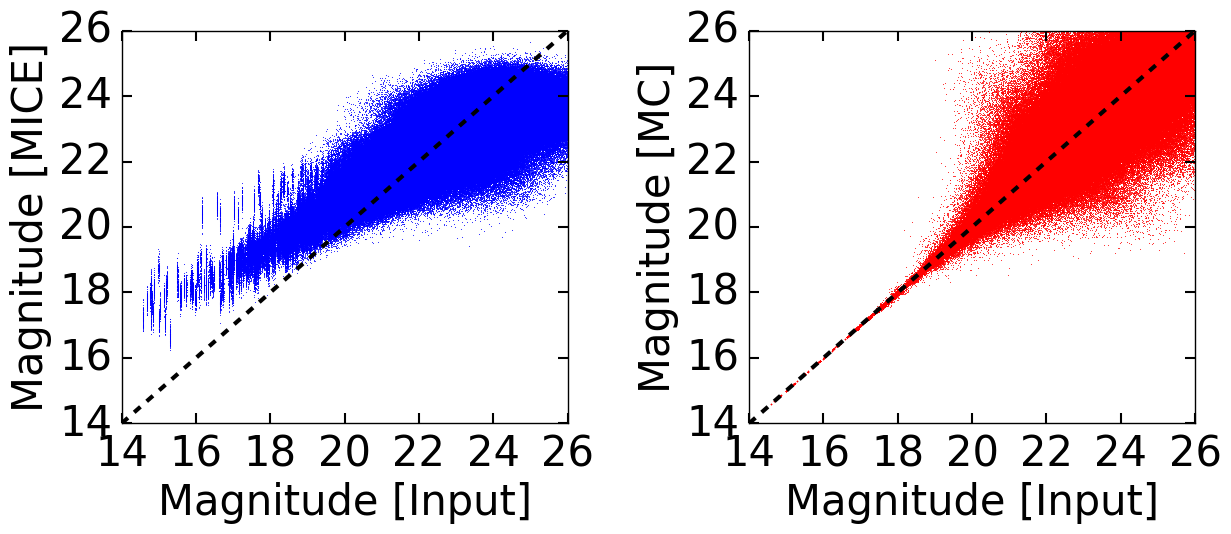

In [11]:
flux_zeropoint = 10**(-0.4*-23.9) # AB magnitude zeropoint

N_mc = 100 # number of Monte Carlo draws

figure(figsize=(13,6))

for i in xrange(N_mc):
    sys.stdout.write(str(i)+' ')
    mag_t, magerr = fz.asinh_mag_map(normal(phot_train,err_train), err_train, 
                                     skynoise=sdss.FDEPTHS, zeropoints=flux_zeropoint) # jitter
    mag_temp = mag_t.copy()
    mag_temp[mask_train==False] = NaN # censor data
    
    # impute missing magnitudes
    mag_impute = fancyimpute.MICE(verbose=False, n_burn_in=20, n_imputations=20).complete(mag_temp)[mask_train==False]
    
    # plotting
    subplot(1,2,1) # actual case: imputed flux
    plot(mag_t[mask_train==False], mag_impute, '.', color='blue', markersize=0.5)
    
    subplot(1,2,2) # ideal case: MC flux
    mag_t2, magerr = fz.asinh_mag_map(normal(phot_train,err_train), err_train, 
                                      skynoise=sdss.FDEPTHS, zeropoints=flux_zeropoint) # jitter
    plot(mag_t[mask_train==False], mag_t2[mask_train==False], '.', color='red', markersize=0.5)
    
subplot(1,2,1)
plot([14,26], [14,26], color='black', lw=3, ls='--')
xlim([14,26])
xlabel('Magnitude [Input]')
ylim([14,26])
ylabel('Magnitude [MICE]')
tight_layout()
subplot(1,2,2)
plot([14,26], [14,26], color='black', lw=3, ls='--')
xlim([14,26])
xlabel('Magnitude [Input]')
ylim([14,26])
ylabel('Magnitude [MC]')
tight_layout()

We see that while MICE seems to work well for the bulk of the sample with magnitudes between 21 and 23.5 or so, it systematically fails at the edges, under and over-predicting our flux densities for bright and faint objects, respectively. Furthermore, the range spanned by the imputed values do not always overlap with their true values, indicating that the PDFs of our imputed values are overly concentrated and biased.

### Targeted Method: WINBET

In addition to an out-of-the-box solver such as FancyImpute, we implement our own method in FRANKEN-Z. The main idea is simple:

1. Impute missing data according to a **Naive Bayes** prior constructed from the (transformed) marginal distribution in each dimension.
2. Find a set of neighbors without explicitly relying on distances using random embedded mappings created by **Extra Trees**.
3. Return a randomly selected neighbor among all neighbors (i.e. using each neighbor's occurence rate as a "poor man's likelihood").

**W**eighted **I**nference with **N**aive **B**ayes and **E**xtra **T**rees (**WINBET**) is implemented within FRANKEN-Z via the *WINBET(...)* class.

In [12]:
# initialize WINBET instance
winbet = fz.WINBET(Ntrees=25) # 25 trees
winbet.train(phot_train*mask_train, err_train*mask_train+1e-20, mask_train) # train on masked photometry

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

One cool feature of WINBET is that, since we're matching up unknown objects to training objects, we can estimate photometric errors in addition to the underlying photometry.

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

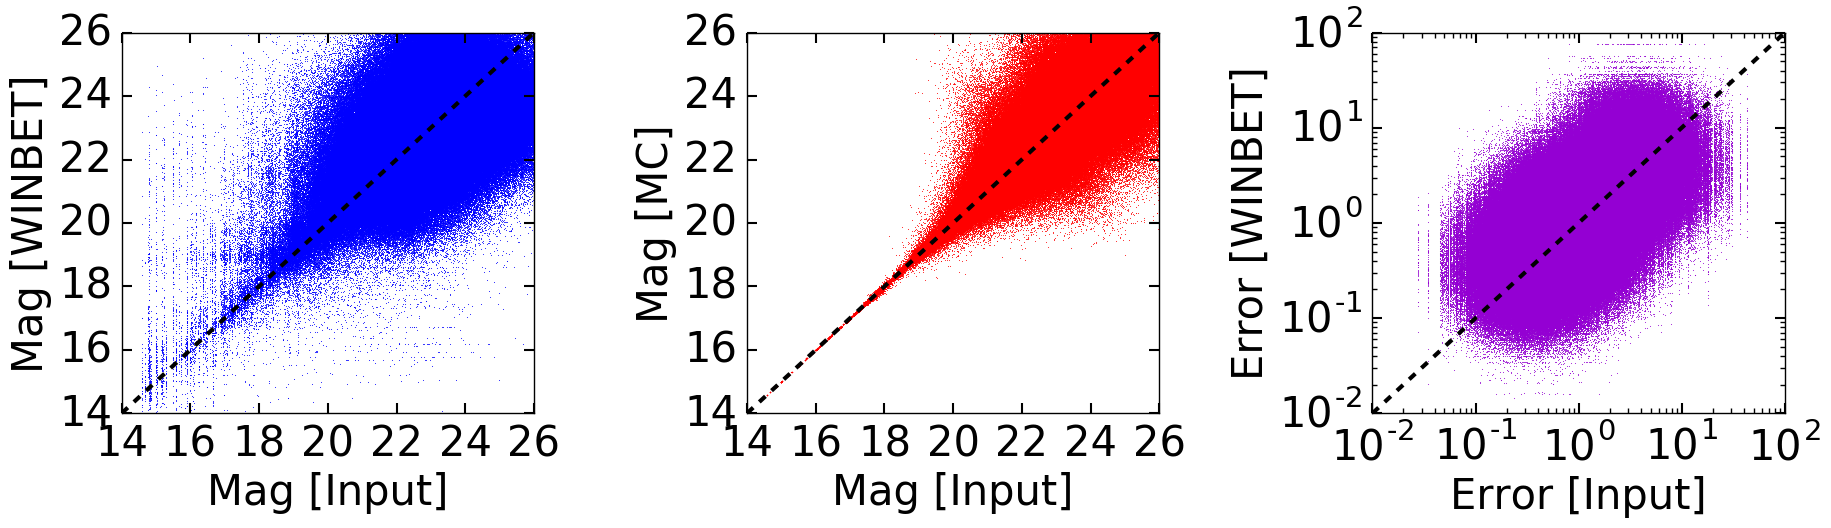

In [13]:
N_mc = 100 # number of Monte Carlo draws

figure(figsize=(19,6))

for i in xrange(N_mc):
    sys.stdout.write(str(i)+' ')
    
    # jitter photometry
    phot_t = normal(phot_train, err_train)
    mag_t, magerr_t = fz.asinh_mag_map(phot_t, err_train, skynoise=sdss.FDEPTHS, zeropoints=flux_zeropoint)
    
    # impute photometry
    phot_t, err_t = winbet.impute(phot_t, err_train, mask_train)
    phot_t[err_t==1e-20], err_t[err_t==1e-20] = NaN, NaN # mask out entries with missing data
    mag_i, magerr_i = fz.asinh_mag_map(normal(phot_t,err_t), err_t, skynoise=sdss.FDEPTHS, zeropoints=flux_zeropoint)
    mag_impute, magerr_impute = mag_i[mask_train==False], magerr_i[mask_train==False]
    
    # jitter photometry
    mag_t2, magerr = fz.asinh_mag_map(normal(phot_train,err_train), err_train, 
                                      skynoise=sdss.FDEPTHS, zeropoints=flux_zeropoint) # jitter
        
    # plotting
    subplot(1,3,1) # actual case: imputed flux
    plot(mag_t[mask_train==False], mag_impute, '.', color='blue', markersize=0.5)
    subplot(1,3,2) # ideal case: MC flux
    plot(mag_t[mask_train==False], mag_t2[mask_train==False], '.', color='red', markersize=0.5)
    subplot(1,3,3)
    loglog(err_train[mask_train==False], err_t[mask_train==False], '.', color='darkviolet', markersize=0.5)
    
    
subplot(1,3,1)
plot([14,26], [14,26], color='black', lw=3, ls='--')
xlim([14,26])
xlabel('Mag [Input]')
ylim([14,26])
ylabel('Mag [WINBET]')
tight_layout()
subplot(1,3,2)
plot([14,26], [14,26], color='black', lw=3, ls='--')
xlim([14,26])
xlabel('Mag [Input]')
ylim([14,26])
ylabel('Mag [MC]')
tight_layout()
subplot(1,3,3)
plot([1e-2, 1e2], [1e-2, 1e2], color='black', lw=3, ls='--')
xlim([1e-2, 1e2])
xlabel('Error [Input]')
ylim([1e-2, 1e2])
ylabel('Error [WINBET]')
tight_layout()

Since we're strictly doing an object assignment rather than interpolation, regions where sampling is sparse in our training (reference) data naturally appear in our imputed values at "streaks" in the output plot. These are not anything to be worried about -- what's more important is that the output object assignments (and subsequent flux samples) are reasonable and trace the true, underlying values in an unbiased way.

Since our Naive Bayes priors are drawn from the target dataset in question (not the dataset we trained on), we can also apply it to new data. While subtle differences in the sample properties might lead to some biases in the inferred fluxes (for instance, if our coverage is poor in certain regions of parameter space, or one sample is substantially biased), this procedure is relatively robust.

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

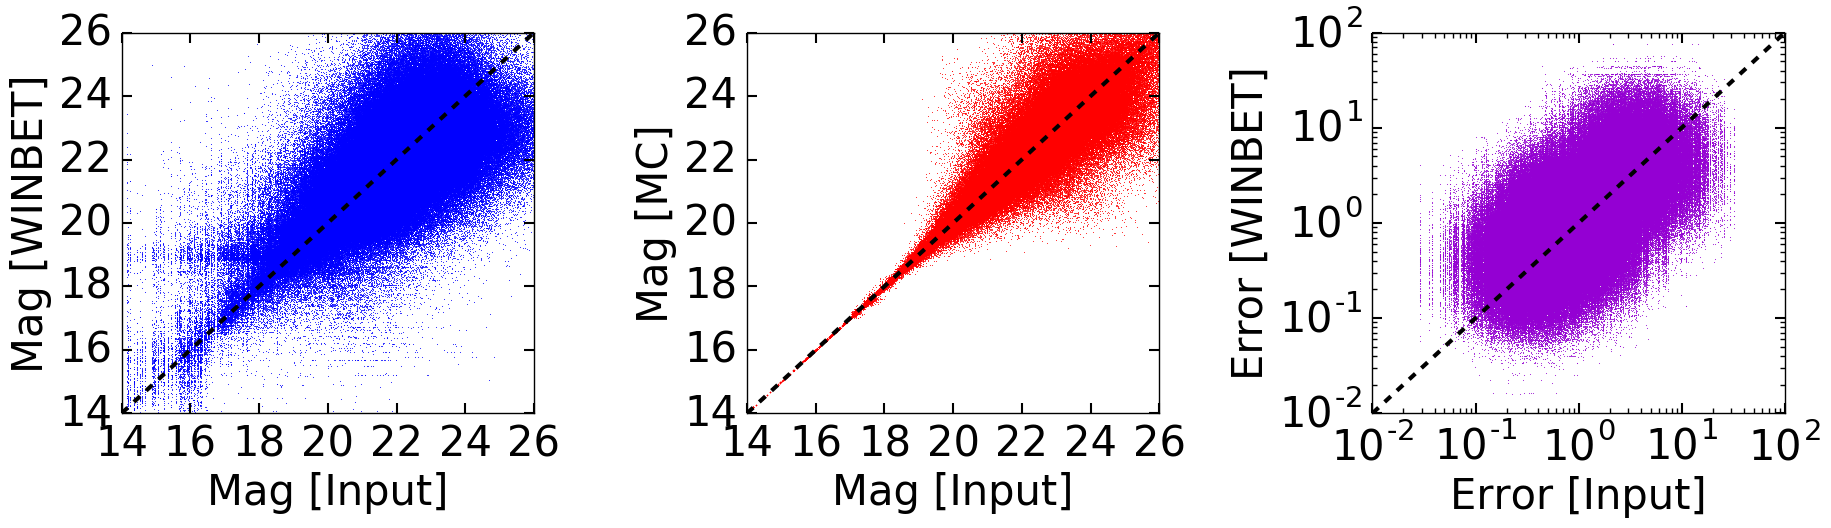

In [14]:
N_mc = 100 # number of Monte Carlo draws

figure(figsize=(19,6))

for i in xrange(N_mc):
    sys.stdout.write(str(i)+' ')
    
    # jitter photometry
    phot_t = normal(phot_test, err_test)
    mag_t, magerr_t = fz.asinh_mag_map(phot_t, err_test, skynoise=sdss.FDEPTHS, zeropoints=flux_zeropoint)
    
    # impute photometry
    phot_t, err_t = winbet.impute(phot_t, err_test, mask_test)
    phot_t[err_t==1e-20], err_t[err_t==1e-20] = NaN, NaN # mask out entries with missing data
    mag_i, magerr_i = fz.asinh_mag_map(normal(phot_t,err_t), err_t, skynoise=sdss.FDEPTHS, zeropoints=flux_zeropoint)
    mag_impute, magerr_impute = mag_i[mask_test==False], magerr_i[mask_test==False]
    
    # jitter photometry
    mag_t2, magerr = fz.asinh_mag_map(normal(phot_test,err_test), err_test, 
                                      skynoise=sdss.FDEPTHS, zeropoints=flux_zeropoint) # jitter
        
    # plotting
    subplot(1,3,1) # actual case: imputed flux
    plot(mag_t[mask_test==False], mag_impute, '.', color='blue', markersize=0.5)
    subplot(1,3,2) # ideal case: MC flux
    plot(mag_t[mask_test==False], mag_t2[mask_test==False], '.', color='red', markersize=0.5)
    subplot(1,3,3)
    loglog(err_test[mask_test==False], err_t[mask_test==False], '.', color='darkviolet', markersize=0.5)
    
    
subplot(1,3,1)
plot([14,26], [14,26], color='black', lw=3, ls='--')
xlim([14,26])
xlabel('Mag [Input]')
ylim([14,26])
ylabel('Mag [WINBET]')
tight_layout()
subplot(1,3,2)
plot([14,26], [14,26], color='black', lw=3, ls='--')
xlim([14,26])
xlabel('Mag [Input]')
ylim([14,26])
ylabel('Mag [MC]')
tight_layout()
subplot(1,3,3)
plot([1e-2, 1e2], [1e-2, 1e2], color='black', lw=3, ls='--')
xlim([1e-2, 1e2])
xlabel('Error [Input]')
ylim([1e-2, 1e2])
ylabel('Error [WINBET]')
tight_layout()

These predictions are not only unbiased as a function of magnitude (and display interesting but real degeneracies), but also give reasonable estimates of the underlying error. Combined, they are a reasonable probe of an object's underlying magnitude.

### Missing Data and FRANKEN-Z

FRANKEN-Z natively incorporates random imputation methods such as WINBET directly into the neighborhood selection process for each member (i.e. for each Monte Carlo iteration). In addition, it allows different instances to possibly be used for the training and testing samples to account for different populations.

In [15]:
# initialize FRANKEN-Z instance
frankenz = fz.FRANKENZ(N_members=25)

# initialize WINBET instance (training)
winbet_train = fz.WINBET(Ntrees=25) # 25 trees
winbet_train.train(phot_train, err_train, mask_train)

# initialize WINBET instance (testing)
winbet_test = fz.WINBET(Ntrees=25) # 25 trees
winbet_test.train(phot_test, err_test, mask_test)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [16]:
model_obj, model_Nobj, model_ll, model_Nbands = frankenz.predict(phot_train, err_train, mask_train, 
                                                                 phot_test, err_test, mask_test, 
                                                                 impute_train=winbet_train, impute_targ=winbet_test)

(0) (1) (2) (3) (4) (5) (6) (7) (8) (9) (10) (11) (12) (13) (14) (15) (16) (17) (18) (19) (20) (21) (22) (23) (24) 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 done!


The *loglikelihood(...)* and  *loglikelihood_s(...)* functions implemented in FRANKEN-Z by default return the approximately band-invariant likelihoods discussed above. We compare the two distributions below.

In [17]:
pstack_fz, pstack_fz2 = zeros(Ntrain), zeros(Ntrain)

for i in arange(Ntest):
    Nm = model_Nobj[i]
    midx = model_obj[i][:Nm]
    
    # with band correction
    ll = model_ll[i][:Nm]
    like = exp(-0.5*(ll-ll.min()))
    pstack_fz[midx] += like/like.sum()
    
    # without band correction
    ll = model_ll[i][:Nm] + model_Nbands[i][:Nm]
    like = exp(-0.5*(ll-ll.min()))
    pstack_fz2[midx] += like/like.sum()

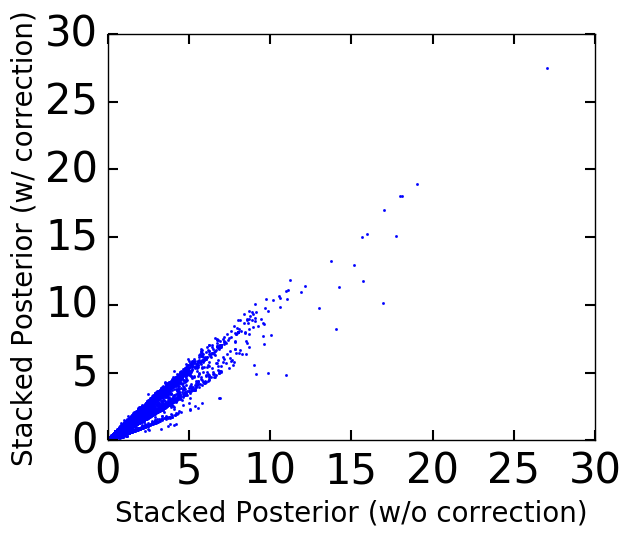

In [18]:
# comparing evidence
figure(figsize(7,6))
plot(pstack_fz2, pstack_fz, '.', markersize=3, color='blue')
xlabel('Stacked Posterior (w/o correction)', fontsize=20)
ylabel('Stacked Posterior (w/ correction)', fontsize=20)
tight_layout()

We notice that while there is broad agreement, some amount of scatter and several "streaks" (based on the number of missing dimensions for the testing/target object) can be clearly seen when comparing our evidences. Let's now see how these differences impact our overall redshift distribution.

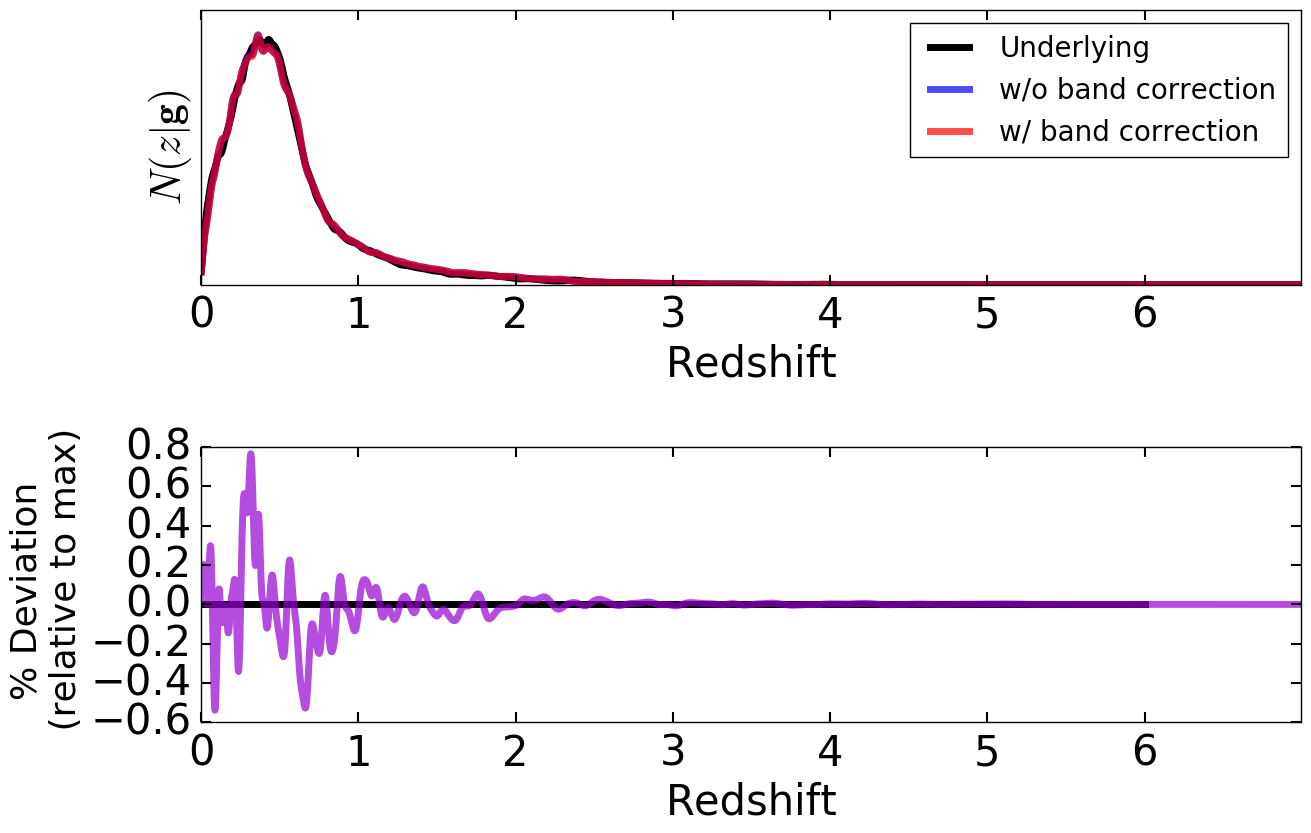

In [19]:
# computing dN/dz (w/ correction)
z_pdf_fz = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel], lzeidx[train_sel], pstack_fz, 
                           rdict.grid, rdict.delta, Ntrain, rdict.Ngrid)
z_pdf_fz = z_pdf_fz[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres)
z_pdf_fz /= z_pdf_fz.sum()

# computing dN/dz (without correction)
z_pdf_fz2 = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel], lzeidx[train_sel], pstack_fz2, 
                            rdict.grid, rdict.delta, Ntrain, rdict.Ngrid)
z_pdf_fz2 = z_pdf_fz2[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres)
z_pdf_fz2 /= z_pdf_fz2.sum()

# truth dN/dz
zpdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[test_sel], lzeidx[test_sel], ones(Ntest),
                       rdict.grid, rdict.delta, Ntest, rdict.Ngrid)
zpdf = zpdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres)
zpdf /= zpdf.sum()

# plotting redshift distribution
figure(figsize=(14,9))
subplot(2,1,1)
plot(rdict.zgrid_highres, zpdf, lw=5, color='black', label='Underlying')
plot(rdict.zgrid_highres, z_pdf_fz2, lw=5, color='blue', alpha=0.7, label='w/o band correction')
plot(rdict.zgrid_highres, z_pdf_fz, lw=5, color='red', alpha=0.7, label='w/ band correction')
xlim([rdict.zgrid_highres.min(), rdict.zgrid_highres.max()])
yticks([])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('$N(z|\mathbf{g})$')
subplot(2,1,2)
plot([0,6], [0,0], lw=5, color='black')
plot(rdict.zgrid_highres, 100*(z_pdf_fz2-z_pdf_fz)/z_pdf_fz.max(), color='darkviolet', lw=5, alpha=0.7)
xlim([rdict.zgrid_highres.min(), rdict.zgrid_highres.max()])
xlabel('Redshift')
ylabel('% Deviation \n (relative to max)', fontsize=26)
tight_layout()

In the case tested here where we're working with a limited number of bands and the majority of our data are well-sampled, the impact of our band correction is essentially negligible. However, as the number of bands increases and more degrees of freedom are permitted, the impact of this correction will likely increase.